## Compare SVC in the case of binary class (Sell, Buy)

In [1]:
import sys
import os
from pathlib import Path

import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_svc,
    plot_strategy,
    select_threshold,
)

In [2]:
metric = "precision"
test_size = 400

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline SVC Classifier without new data + r

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2024, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-13 23:13:23,397] A new study created in memory with name: no-name-13d9acea-27f0-46a6-b34f-32a2eab18cf7
[I 2024-02-13 23:13:30,445] Trial 0 finished with value: 0.5349221812317639 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 31.452426512790613, 'gamma': 'scale', 'shrinking': False}. Best is trial 0 with value: 0.5349221812317639.
[I 2024-02-13 23:13:38,629] Trial 1 finished with value: 0.5313803028582007 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 54.53613113150663, 'gamma': 'scale', 'shrinking': False}. Best is trial 0 with value: 0.5349221812317639.
[I 2024-02-13 23:13:38,959] Trial 2 finished with value: 0.49296330466802585 and parameters: {'kernel': 'sigmoid', 'degree': 3, 'C': 7.071811784343496, 'gamma': 'auto', 'shrinking': True}. Best is trial 0 with value: 0.5349221812317639.
[I 2024-02-13 23:13:39,490] Trial 3 finished with value: 0.5153902296753667 and parameters: {'kernel': 'rbf', 'degree': 8, 'C': 0.05825276666509617, 'gamma': 'scale', 'shrinking'

Number of finished trials: 150
Best trial:
  Value: 0.6019571617802745
  Params: 
    kernel: rbf
    degree: 2
    C: 55.06525595079029
    gamma: auto
    shrinking: True


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**trial.params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=55.06525595079029, degree=2, gamma='auto',
                     probability=True, random_state=1968))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

0.7053231939163498

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.61


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.5175

              precision    recall  f1-score   support

           0       0.59      0.91      0.71       236
           1       0.37      0.08      0.13       164

    accuracy                           0.57       400
   macro avg       0.48      0.49      0.42       400
weighted avg       0.50      0.57      0.47       400



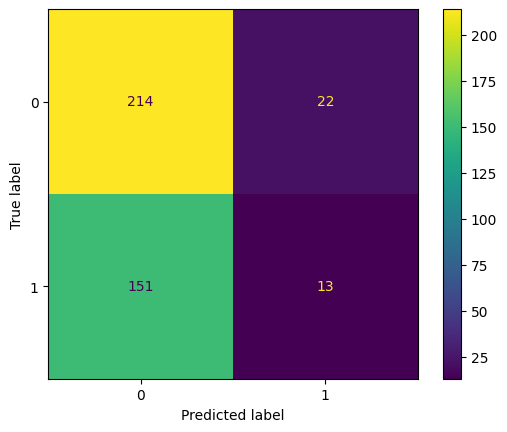

In [18]:
display_report(y_test, predictions)

In [19]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [20]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [21]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-03-14,1,416.0,11.15,2022-04-04,456.799988,29.649988,29.649988,29.649988,29.649988
2022-03-15,0,426.0,9.43,2022-04-04,456.799988,0.000000,21.369988,29.649988,51.019976
2022-03-16,0,436.0,7.90,2022-04-06,446.519989,0.000000,2.619989,29.649988,53.639965
2022-03-17,0,440.0,7.72,2022-04-06,446.519989,0.000000,-1.200011,29.649988,52.439954
2022-03-18,0,444.0,8.93,2022-04-08,447.570007,0.000000,-5.359993,29.649988,47.079961
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,-45.640018,61.179850
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,-45.640018,58.159843
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,-45.640018,58.399835


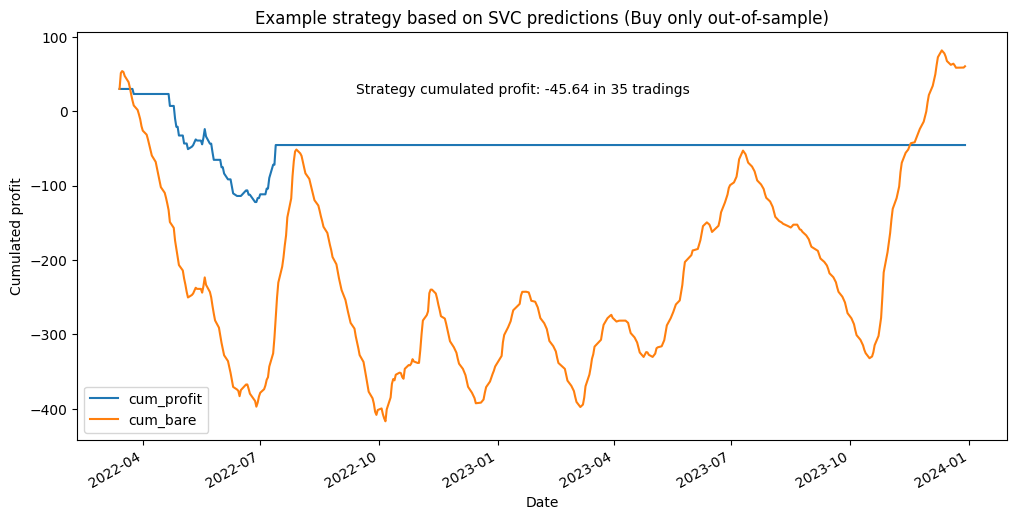

In [22]:
plot_strategy(strategy_df, "SVC", "(Buy only out-of-sample)")

In [23]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## SVC with data from MC simulation and additional features

In [24]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [25]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [27]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-13 23:15:09,744] A new study created in memory with name: no-name-d21b70bb-78ef-4917-b300-b8610c2a29bf


[I 2024-02-13 23:15:12,237] Trial 0 finished with value: 0.5571397749872977 and parameters: {'kernel': 'poly', 'degree': 6, 'C': 58.246152254253985, 'gamma': 'auto', 'shrinking': False}. Best is trial 0 with value: 0.5571397749872977.
[I 2024-02-13 23:15:14,603] Trial 1 finished with value: 0.5699678923497277 and parameters: {'kernel': 'poly', 'degree': 6, 'C': 88.76782521053377, 'gamma': 'auto', 'shrinking': False}. Best is trial 1 with value: 0.5699678923497277.
[I 2024-02-13 23:15:15,124] Trial 2 finished with value: 0.5435431915073253 and parameters: {'kernel': 'poly', 'degree': 5, 'C': 0.010942849369889686, 'gamma': 'auto', 'shrinking': False}. Best is trial 1 with value: 0.5699678923497277.
[I 2024-02-13 23:15:16,035] Trial 3 finished with value: 0.6375540160586668 and parameters: {'kernel': 'rbf', 'degree': 2, 'C': 76.0380640670177, 'gamma': 'scale', 'shrinking': True}. Best is trial 3 with value: 0.6375540160586668.
[I 2024-02-13 23:15:16,716] Trial 4 finished with value: 0.585

Number of finished trials: 150
Best trial:
  Value: 0.6437907473117288
  Params: 
    kernel: rbf
    degree: 2
    C: 38.46691043843824
    gamma: scale
    shrinking: True


In [28]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**study.best_params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [29]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=38.46691043843824, degree=2, probability=True,
                     random_state=1968))])

In [30]:
# In-sample score
pipe.score(X_train, y_train)

0.7785171102661597

In [31]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.65


In [32]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [33]:
pipe.score(X_test, y_test)

0.44

              precision    recall  f1-score   support

           0       0.60      0.66      0.62       236
           1       0.42      0.36      0.39       164

    accuracy                           0.54       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.52      0.54      0.53       400



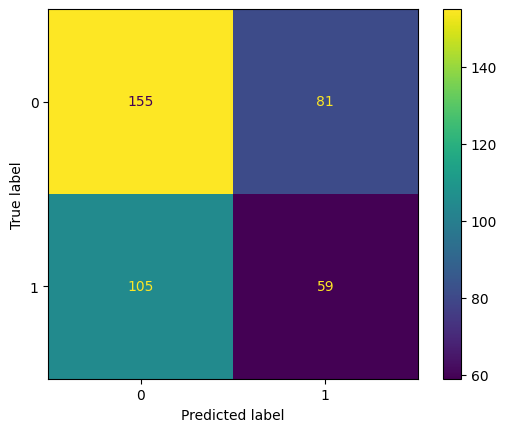

In [34]:
display_report(y_test, predictions)

In [35]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [36]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [37]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-03-14,1,416.0,11.15,2022-04-04,456.799988,29.649988,29.649988,29.649988,29.649988
2022-03-15,0,426.0,9.43,2022-04-04,456.799988,0.000000,21.369988,29.649988,51.019976
2022-03-16,0,436.0,7.90,2022-04-06,446.519989,0.000000,2.619989,29.649988,53.639965
2022-03-17,0,440.0,7.72,2022-04-06,446.519989,0.000000,-1.200011,29.649988,52.439954
2022-03-18,0,444.0,8.93,2022-04-08,447.570007,0.000000,-5.359993,29.649988,47.079961
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,40.829943,61.179850
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,40.829943,58.159843
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,40.829943,58.399835


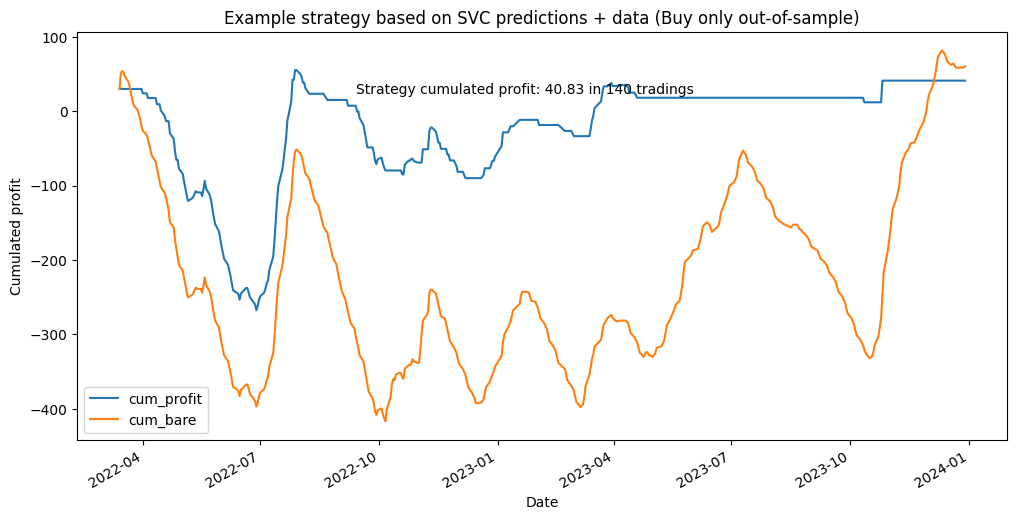

In [38]:
plot_strategy(strategy_df, "SVC", "+ data (Buy only out-of-sample)")

In [39]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [40]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [41]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
9,1,22.889988,0,29.649988,7.509961
14,0,22.889988,1,23.709988,-26.320039
16,0,22.889988,1,17.409988,-38.030039
21,0,22.889988,1,9.139988,-76.570039
24,0,22.889988,1,0.749988,-102.200039
...,...,...,...,...,...
254,0,-45.640018,1,31.799932,-284.419923
255,0,-45.640018,1,24.619932,-291.599923
258,0,-45.640018,1,17.819932,-310.799918
356,0,-45.640018,1,11.729934,-320.670063


In [42]:
compare_df[mask_out].shape

(107, 5)

In [43]:
compare_df.sum(axis=0)

bare_rf_pred_out          35.000000
cum_profit_out        -17610.656377
mmar_rf_pred_out         140.000000
mmar_cum_profit_out   -10157.072058
mmar_cum_bare_out     -89134.646364
dtype: float64

<Axes: title={'center': 'Stategy comparison'}, ylabel='Profit'>

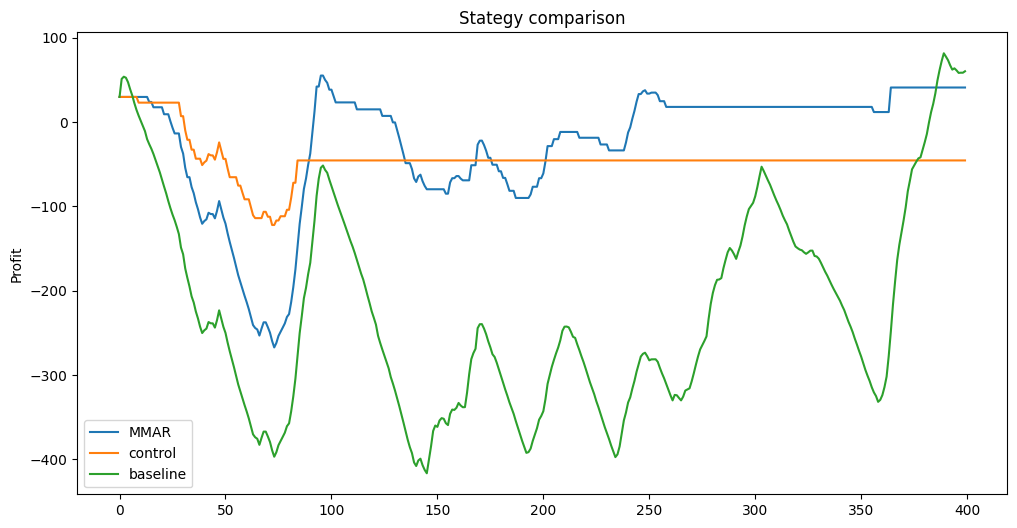

In [44]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")